<a href="https://colab.research.google.com/github/geopayme/AstroPhysics/blob/main/DLSFH_Section_1_2_3_Merged_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 📦 Section 1: Install & Imports

In [1]:
# ===============================
# 📦 Section 1: Install & Imports
# ===============================

# -- Install OCR dependencies (for image date detection) --
!apt-get update -qq > /dev/null
!apt-get install -y tesseract-ocr > /dev/null
!pip install pytesseract --quiet

# -- Python Libraries --
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from pathlib import Path
from PIL import Image
import pytesseract
import cv2
import json
import re
from google.colab import files

# ✅ Confirm setup
print("✅ All dependencies installed and imports loaded.")


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ All dependencies installed and imports loaded.


## 📂 Section 2: Image Upload + Date Detection

In [2]:
# ===============================
# 📂 Section 2: Image Upload + Date Detection (FIXED)
# ===============================

from google.colab import files
uploaded = files.upload()
image_path = next(iter(uploaded))

def extract_date(image_path):
    filename = image_path

    # Try filename pattern: bbzqaYYMMDD
    import re
    match = re.search(r'bbzqa(\d{6})', filename)
    if match:
        yymmdd = match.group(1)
        year = int('20' + yymmdd[:2])
        month = int(yymmdd[2:4])
        day = int(yymmdd[4:6])
        try:
            return datetime(year, month, day)
        except:
            pass

    # OCR fallback
    try:
        from PIL import Image
        import pytesseract
        img = Image.open(image_path)
        text = pytesseract.image_to_string(img)
        print("🧠 OCR output:", text[:100])  # Debug preview

        date_match = re.search(r"(\d{4})[/-](\d{1,2})[/-](\d{1,2})", text)
        if date_match:
            year, month, day = map(int, date_match.groups())
            return datetime(year, month, day)
    except Exception as e:
        print("⚠️ OCR failed:", e)

    # Manual fallback
    try:
        manual = input("Enter image date (YYYY-MM-DD): ")
        return datetime.strptime(manual.strip(), "%Y-%m-%d")
    except:
        return None

image_date = extract_date(image_path)
print("🕒 Image Date:", image_date)


Saving bbzqa150802t0034_dim-860.jpg to bbzqa150802t0034_dim-860.jpg
🕒 Image Date: 2015-08-02 00:00:00


## 🧮 Section 3: Entropy Map Generation (Sobel + Variance)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


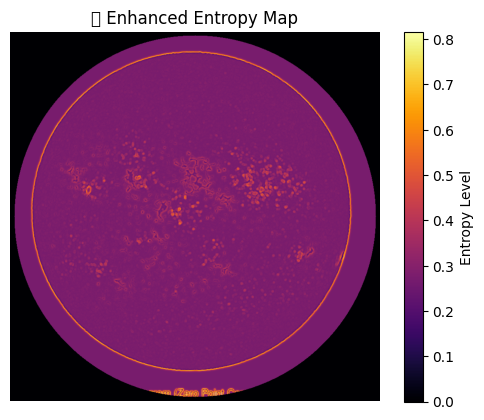

In [3]:
# ===============================
# 🧮 Section 3: Entropy Map Generation (Sobel + Variance)
# ===============================

from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the image and convert to grayscale
img = Image.open(image_path).convert('L')
img_array = np.array(img)

# Create a circular mask (approximate solar disk)
h, w = img_array.shape
cx, cy = w // 2, h // 2
radius = min(cx, cy) - 10
y_idx, x_idx = np.ogrid[:h, :w]
mask = (x_idx - cx)**2 + (y_idx - cy)**2 <= radius**2
disk_pixels = img_array[mask]

# Sobel gradient magnitude
sobelx = cv2.Sobel(img_array, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(img_array, cv2.CV_64F, 0, 1, ksize=5)
magnitude = np.sqrt(sobelx**2 + sobely**2)

# Local variance (blur - sharpen)
blurred = cv2.GaussianBlur(img_array, (9, 9), 0)
local_var = cv2.Laplacian(blurred, cv2.CV_64F)

# Normalize both and combine into enhanced entropy signal
grad_norm = (magnitude - np.min(magnitude)) / (np.ptp(magnitude) + 1e-8)
var_norm = (local_var - np.min(local_var)) / (np.ptp(local_var) + 1e-8)
enhanced_entropy = (grad_norm + var_norm) / 2.0

# Apply mask
entropy_map = np.zeros_like(img_array, dtype=float)
entropy_map[mask] = enhanced_entropy[mask]

# Save to standard path
np.save("DLSFH_entropy_map_full.npy", entropy_map)

# 🔍 Visualize the entropy map
plt.imshow(entropy_map, cmap='inferno')
plt.title("🧮 Enhanced Entropy Map")
plt.axis('off')
plt.colorbar(label='Entropy Level')
plt.show()
